In [4]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import os
import re
from pyvis.network import Network
import community.community_louvain
from functions import *


In [5]:
# Download spacy english model
!py -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


You should consider upgrading via the 'C:\Users\ptisc\Documents\LUIS_PROGRAMACIÓN\Projects\LOTR NLP\Scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
# Load the model
NER = spacy.load('en_core_web_sm')

# Load books

In [7]:
# Get all the book files in our data folder

all_books = [b for b in os.scandir(r'C:\Users\ptisc\Documents\LUIS_PROGRAMACIÓN\Projects\LOTR NLP\Data') if '.txt' in b.name]
all_books

[<DirEntry '01 - The Fellowship Of The Ring.txt'>,
 <DirEntry '02 - The Two Towers.txt'>,
 <DirEntry '03 - The Return Of The King.txt'>]

In [8]:
# Let's read, apply NER and see the result for the first book
book = all_books[0]
book_text = open(book).read()

# Increase NER max length
NER.max_length = len(book_text)
book_doc = NER(book_text)

In [9]:
# Visualize first 2000 lines

displacy.render(book_doc[0:2000],style='ent', jupyter=True)

# Read Characters

In [10]:
chars_df = pd.read_csv(r'C:\Users\ptisc\Documents\LUIS_PROGRAMACIÓN\Projects\LOTR NLP\Loads\characters.csv',sep=';')

In [11]:
# Remove brackets and text within brackets

chars_df['char_name'] = chars_df['char_name'].apply(lambda x: re.sub("[\(].*?[\)]","",x))
chars_df['character_firstname'] = chars_df['char_name'].apply(lambda x: x.split(' ',1)[0])

In [12]:
chars_df.head()

,char_name,character_firstname
0,Aragorn II Elessar,Aragorn
1,Arwen,Arwen
2,Frodo Baggins,Frodo
3,Beregond,Beregond
4,Bergil,Bergil


# Get named entity list per sentence

In [13]:
sent_ent_df = []

# Loop through sentences, store named entity list for each sentence

for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_ent_df.append({'sentence':sent, 'entities':entity_list})

sent_ent_df = pd.DataFrame(sent_ent_df)

In [14]:
# Function to filter non character names entities from our sent_ent_df

def filter_ent(ent_list, char_df):
    return [ent for ent in ent_list 
            if ent in list(char_df.char_name)
            or ent in list(char_df.character_firstname)]

In [15]:
sent_ent_df['char_entities'] = sent_ent_df['entities'].apply(lambda x: filter_ent(x,chars_df))

In [16]:
# Remove no-entity sentences

sent_ent_df_filtered = sent_ent_df[sent_ent_df['char_entities'].map(len) > 0]

In [17]:
sent_ent_df_filtered['char_entities'] = sent_ent_df_filtered['char_entities'].apply(lambda x: [item.split()[0] for item in x])

C:\Users\ptisc\AppData\Local\Temp\ipykernel_12008\244998528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_ent_df_filtered['char_entities'] = sent_ent_df_filtered['char_entities'].apply(lambda x: [item.split()[0] for item in x])


In [18]:
sent_ent_df_filtered.head()

,sentence,entities,char_entities
7,"(The, process, had, begun, in, the, writing, o...","[Gondolin, Durin, Moria, Gandalf, Necromancer,...",[Gandalf]
16,"(\n , It, was, during, 1944, that, ,, leav...","[1944, 1, Frodo, Mordor]",[Frodo]
88,"(But, in, the, days, of, Bilbo, ,, and, of, Fr...","[the days, Bilbo]",[Bilbo]
90,"(Of, their, original, home, the, Hobbits, in, ...","[Hobbits, Bilbo]",[Bilbo]
111,"(Even, in, Bilbo, 's, time, the, strong, Fallo...",[Bilbo],[Bilbo]


# Create relationship

In [19]:
# Create a sliding window to read sentences and extract entities

window_size = 5
relationships = []

for i in range(sent_ent_df_filtered.index[-1]):
    end_i = min(i + 5, sent_ent_df_filtered.index[-1]) # Solves out of index when reading last line for df
    char_list = sum((sent_ent_df_filtered.loc[i: end_i].char_entities), [])

    # Remove duplicated characters
    char_unique = [char_list[i] for i in range(len(char_list))
                    if (i==0) or char_list[i]!=char_list[i-1]]

    # Append relationship into the list if there are more than 2 characters in the window
    if len(char_unique)>2:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx+1]
            relationships.append({"source": a, "target": b})

# To DataFrame
relationships_df = pd.DataFrame(relationships)

In [20]:
# Sort the cases with a->b and b->a

relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis=1), columns= relationships_df.columns)


In [21]:
relationships_df["value"] = 1
relationships_df = relationships_df.groupby(["source","target"],sort=False, as_index=False).sum()

In [22]:
relationships_df

,source,target,value
0,Bilbo,Gollum,118
1,Bilbo,Frodo,338
2,Gandalf,Gollum,16
3,Bilbo,Gandalf,80
4,Celeborn,Elrond,5
...,...,...,...
105,Celeborn,Merry,3
106,Celeborn,Sam,5
107,Galadriel,Legolas,9
108,Aragorn,Galadriel,6


# Graph Analysis and visualization

In [23]:
# Create a graph from a pandas dataframe

G = nx.from_pandas_edgelist(relationships_df,
                            source='source',
                            target='target',
                            edge_attr='value',
                            create_using=nx.Graph())

## Graph Visualization - Pyvis

In [24]:
# Let's create the network. I am currently using VSC, and it doesn't display the html. If you are using Jupyter lab directly
# feel free to change notebook argument to True. And the path to your html.
path_html = r'C:\Users\ptisc\Documents\LUIS_PROGRAMACIÓN\Projects\LOTR NLP\Loads\lotr.html'
net = Network(notebook=False, width="1000px", height="700px", bgcolor='#222222',font_color='white')

# Counts how many links a node has, usefull for node size
node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show(path_html)

# Centrality Measures - Most important characters

In [25]:
# We're gonna define a plot function

def show_cent(dict):
    df = pd.DataFrame.from_dict(dict,orient='index', columns=['centrality'])
    df.sort_values('centrality', ascending=False)[0:9].plot(kind='bar')

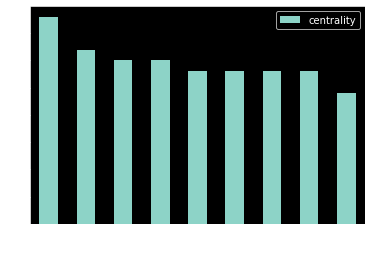

In [26]:
# Degree centrality

degree_dict = nx.degree_centrality(G)
show_cent(degree_dict)

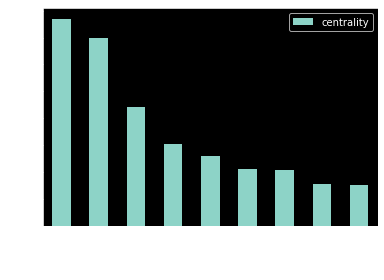

In [27]:
# Betweenness Centrality

betweenness_dict = nx.betweenness_centrality(G)
show_cent(betweenness_dict)



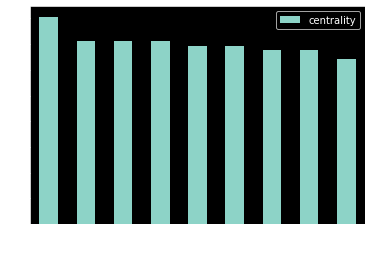

In [28]:
# Closeness centrality

closeness_dict = nx.closeness_centrality(G)
show_cent(closeness_dict)

In [29]:
# Save measures

nx.set_node_attributes(G,degree_dict,'degree_centrality')
nx.set_node_attributes(G,betweenness_dict,'betweenness_centrality')
nx.set_node_attributes(G,closeness_dict,'closeness_centrality')

# Community Detection

In [30]:
# Let's compute the communities each character belongs to
communities = community.community_louvain.best_partition(G)

# Save the dict as attribute for different plot colors for each group
nx.set_node_attributes(G, communities, 'group')

com_net = Network(notebook=False, width="1000px", height="700px", bgcolor='#222222',font_color='white')
com_net.from_nx(G)
com_net.show('lotr_communities.html')

# Evolution of character's importance

In [31]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir(r'C:\Users\ptisc\Documents\LUIS_PROGRAMACIÓN\Projects\LOTR NLP\Data') if '.txt' in b.name]

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [32]:
# Loop trhough book list and create graphs
from functions import *
for book in all_books:
    
    book_text = ner(book)

    # Get list of entities per sentences
    sent_ent_df = get_ne_list_per_sentence(book_text)

    # Select only character entities
    sent_ent_df['character_entities'] = sent_ent_df['entities'].apply(lambda x: filter_entity(x, chars_df))

    # Filter out sentences that don't have any character entities
    sent_ent_df_filtered = sent_ent_df[sent_ent_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_ent_df_filtered['character_entities'] = sent_ent_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])
     # Create relationship df
    relationship_df = create_relationships(df = sent_ent_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G)


C:\Users\ptisc\AppData\Local\Temp\ipykernel_12008\1751758906.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_ent_df_filtered['character_entities'] = sent_ent_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
C:\Users\ptisc\AppData\Local\Temp\ipykernel_12008\1751758906.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_ent_df_filtered['character_entities'] = sent_ent_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
C:\Users\ptisc\AppData\Local\Temp\ipykerne

<AxesSubplot:>

<Figure size 1080x1080 with 0 Axes>

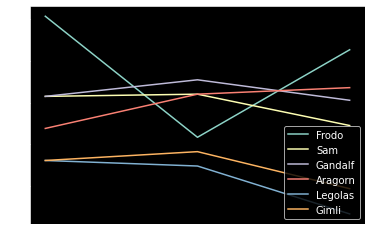

In [34]:
# Creating a list of degree centrality of all the books

evol = [nx.degree_centrality(book) for book in books_graph ]

# Creating a DataFrame from the list of degree centralities in all the books

degree_evol_df = pd.DataFrame.from_records(evol)

# Plot the degree centrality evolution of 5 main characters
plt.figure(figsize=(15,15))
degree_evol_df[['Frodo','Sam','Gandalf','Aragorn','Legolas','Gimli']].plot()